# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image
import numpy as np

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in Drive for use in this Colab notebook.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone/data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

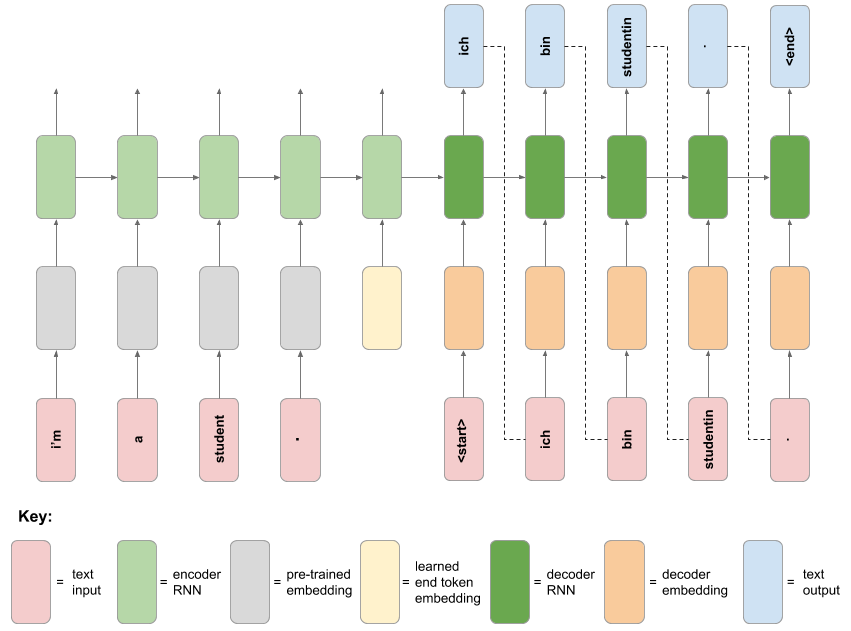

In [ ]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [ ]:
# Create separate lists of English and German sentences, and preprocess them using the preprocess_sentence function provided for you above.

data_examples_split = [x.split('\t') for x in data_examples]
eng_sentence_pre = [preprocess_sentence(x[0]) for x in data_examples_split]
ger_sentence_pre = [preprocess_sentence(x[1]) for x in data_examples_split]

In [ ]:
# Add a special "<start>" and "<end>" token to the beginning and end of every German sentence.
ger_sentence_pre = [f'<start> {x} <end>' for x in ger_sentence_pre]

In [ ]:
#Use the Tokenizer class from the tf.keras.preprocessing.text module to tokenize the German sentences, 
#ensuring that no character filters are applied. Hint: use the Tokenizer's "filter" keyword argument.

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None, 
                      filters='',
                      lower=False,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>')

# fit to text
tokenizer.fit_on_texts(ger_sentence_pre)

In [ ]:
# Inspect data

tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [ ]:
# # Save word_index and index_word as python dictionaries
import json
ger_index_word = json.loads(tokenizer_config['index_word'])
ger_word_index = json.loads(tokenizer_config['word_index'])

In [ ]:
# Map the sentences to tokens
ger_sentence_token = tokenizer.texts_to_sequences(ger_sentence_pre)

In [ ]:
# Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, 
# print out the text (with start and end tokens) as well as the tokenized sequence.

# Randomly permute a sequence, and pick 5 example
permute_seq  = np.random.permutation(len(data_examples))[:5]

# Print text
for index in permute_seq:
    print(f'English : {eng_sentence_pre[index]} ')
    print(f'German : {ger_sentence_pre[index]}')
    print(f'German Token : {ger_sentence_token[index]}\n')

English : can i go with you ? 
German : <start> kann ich mit ihnen gehen ? <end>
German Token : [2, 31, 5, 56, 125, 46, 8, 3]

English : tom may be weak . 
German : <start> tom koennte schwach sein . <end>
German Token : [2, 6, 211, 490, 55, 4, 3]

English : no one cheated . 
German : <start> niemand schummelte . <end>
German Token : [2, 100, 1869, 4, 3]

English : i felt betrayed . 
German : <start> ich fuehlte mich hintergangen . <end>
German Token : [2, 5, 235, 23, 2115, 4, 3]

English : don't make me go . 
German : <start> wenn du so weitermachst , muss ich gehen . <end>
German Token : [2, 1208, 14, 71, 4741, 26, 86, 5, 46, 4, 3]



In [ ]:
# Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_ger_sentence_token = pad_sequences(ger_sentence_token , padding= 'post')

## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [ ]:
# Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation 
# (NB: each English dataset example is a single sentence string, 
# and each German dataset example is a sequence of padded integer tokens).

from sklearn.model_selection import train_test_split

eng_train,eng_valid,ger_train,ger_valid = train_test_split(eng_sentence_pre,padded_ger_sentence_token,test_size = 0.20) # shuffe

In [ ]:
# Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
train_dataset = tf.data.Dataset.from_tensor_slices((eng_train,ger_train))
val_dataset = tf.data.Dataset.from_tensor_slices((eng_valid,ger_valid))

In [ ]:
# Inspect the shape
print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
# Create a function to map over the datasets that splits each English sentence at spaces. 
# Apply this function to both Dataset objects using the map method. Hint: look at the tf.strings.split function.

def split_eng(eng,ger):
    # Split elements of input(string) based on sep into a RaggedTensor.
    eng = tf.strings.split(eng, sep=' ')
    # untoch german token
    return eng,ger
    
# apply to dataset by using map method
train_dataset = train_dataset.map(split_eng)
val_dataset  = val_dataset.map(split_eng)

In [ ]:
# Inspect the shape
print(train_dataset.element_spec) # ragged tensor for eng data
print(val_dataset.element_spec)

(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
# Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model.
# Apply this function to both Dataset objects using the map method.

def embed_eng(eng,ger):
    # pass in tensor of string word in layer and output embedding
    eng = embedding_layer(eng)
    return eng,ger

# apply to dataset by using map method
train_dataset = train_dataset.map(embed_eng)
val_dataset  = val_dataset.map(embed_eng)

In [ ]:
# Inspect the shape
print(train_dataset.element_spec) # rag array of 128 feature embedded 
print(val_dataset.element_spec)

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
# Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length.
# Apply this function to both Dataset objects using the filter method.

def filter_length(eng,ger):
    
    length = tf.constant(13,dtype = tf.int32)

    return tf.math.greater(length,tf.cast(len(eng),tf.int32))


# Filter dataset both
train_dataset = train_dataset.filter(filter_length)
val_dataset  = val_dataset.filter(filter_length)

In [ ]:
# Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, 
# so that each sequence is length 13. Apply this function to both Dataset objects using the map method. 
# Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful.

def pad_eng(eng,ger):
    # input shape rank 2 (None , 128)
    # paddings is an integer list with shape [n, 2], where n is the rank of tensor
    #  For each dimension D of input, paddings[D, 0] indicates how many values to add before the contents of tensor
    #  we have rank 2 tensor so paddings = [[dim0(num_word)],[dim1(embedding)]]
    # The len() function returns the number of items in an object. Must be a sequence or a collection. In this case a number of word
    # pad until the length is equal to 13 = add 13-len(eng)
    paddings = [[13-len(eng),0] , [0,0]]
    eng = tf.pad(eng, paddings = paddings, mode='CONSTANT', constant_values=0)
    return eng,ger

# apply to dataset by using map method
train_dataset = train_dataset.map(pad_eng)
val_dataset  = val_dataset.map(pad_eng)

In [ ]:
# Batch both training and validation Datasets with a batch size of 16.
train_dataset = train_dataset.batch(16,drop_remainder=True)
val_dataset  = val_dataset.batch(16,drop_remainder=True)

In [ ]:
#Using the Dataset .take(1) method, print the shape of the English data example from the training Dataset.
print(next(iter(train_dataset.take(1)))[0].shape)

(16, 13, 128)


In [ ]:
# Using the Dataset .take(1) method, print the German data example Tensor from the validation Dataset.
print(next(iter(val_dataset.take(1)))[1])

tf.Tensor(
[[   2 1464   14   12  248    8    3    0    0    0    0    0    0    0]
 [   2   39   78   20 2103   10    3    0    0    0    0    0    0    0]
 [   2  451  886   10    3    0    0    0    0    0    0    0    0    0]
 [   2   43 1086    7   11    8    3    0    0    0    0    0    0    0]
 [   2   22    7 1286    4    3    0    0    0    0    0    0    0    0]
 [   2    7    6 1040    8    3    0    0    0    0    0    0    0    0]
 [   2    5   16 1147    4    3    0    0    0    0    0    0    0    0]
 [   2    9   24  142    4    3    0    0    0    0    0    0    0    0]
 [   2    5   16   13   48 5733    4    3    0    0    0    0    0    0]
 [   2   80 1233 1082   10    3    0    0    0    0    0    0    0    0]
 [   2   33   14 1487    8    3    0    0    0    0    0    0    0    0]
 [   2   44   49  186    8    3    0    0    0    0    0    0    0    0]
 [   2   18   46   66 2631    4    3    0    0    0    0    0    0    0]
 [   2   27 5109 5110    4    3    0    

In [ ]:
#for i in iter(train_dataset):
  #assert (i[0].shape[1] == 13) # re-check the lenthg of english input to make sure it has 13 sequence length

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

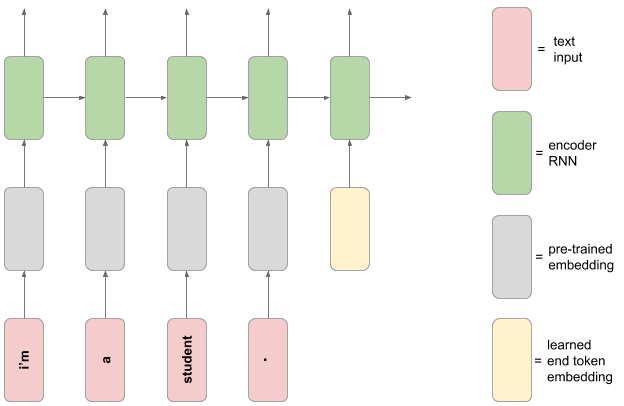

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [ ]:
from tensorflow.keras.layers import Layer

class AddEndToken(Layer):
  def __init__(self, **kwargs):
    super(AddEndToken, self).__init__(**kwargs)

  def build(self, input_shape):
    # need to have one variable with  128 embedding vector so the shape must be  (1, 1, 128) not (sample , 1 , 128) this will make every end token in the sample diffent
    self.end_token = self.add_weight(shape=(1,1,input_shape[-1],), #  must be the same rank as inputs (sample , lenthg , embedding)
                                          initializer='random_uniform',
                                         trainable= True , name='end_token')
  def call(self, inputs):
    # we have 1 varialbe but it need to concatenate to every sample in batch (with the same variable)
    token = tf.tile(self.end_token,[tf.shape(inputs)[0],1,1]) # repeat along sample axis
    return tf.keras.layers.concatenate([inputs, token], axis=1) # concatenate require same dimension except concatenate axis

''' 
Note!! 
 when defining custom layers and models for graph mode, prefer the dynamic tf.shape(x) over the static x.shape
'''


' \nNote!! \n when defining custom layers and models for graph mode, prefer the dynamic tf.shape(x) over the static x.shape\n'

In [ ]:
'''
Using the Dataset .take(1) method, extract a batch of English data examples from the training Dataset and print the shape.
 Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).
'''
for eng,ger in train_dataset.take(1):
  print(eng.shape)
  add_emb = AddEndToken()
  new_tensor = add_emb(eng)
  print(new_tensor.shape)

(16, 13, 128)
(16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [ ]:
# Create Model
from tensorflow.keras import Input , Model
from tensorflow.keras.layers import Masking , LSTM

def create_encoder():
  # Input shape
  shape_inputs = (13,128) # no batch size 
  
  # The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
  inputs = Input(shape = shape_inputs , name ='inputs_sequence')
  # The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
  x = AddEndToken(name = 'add_end_token')(inputs)
  # This is followed by a Masking layer, with the mask_value set to the distinct padding value you used when you padded the English
  x = Masking(mask_value=0 , name = 'mask')(x)
  # The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
  output_seq , hidden_state, cell_state  = LSTM(512,return_sequences=True, return_state=True)(x)
  # The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
  model = Model(inputs = inputs , outputs = [hidden_state,cell_state])

  return model

In [ ]:
# Using the Dataset .take(1) method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor,

encoder_model = create_encoder()

for eng,ger in train_dataset.take(1):
  hidden_state , cell_state = encoder_model(eng)

# print shape of the output tensor
print(tf.shape(hidden_state))
print(tf.shape(cell_state))

tf.Tensor([ 16 512], shape=(2,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


In [ ]:
# Print the model summary for the encoder network.
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_sequence (InputLayer  [(None, 13, 128)]        0         
 )                                                               
                                                                 
 add_end_token (AddEndToken)  (None, 14, 128)          128       
                                                                 
 mask (Masking)              (None, 14, 128)           0         
                                                                 
 lstm (LSTM)                 [(None, 14, 512),         1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
___________________________________________________

## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

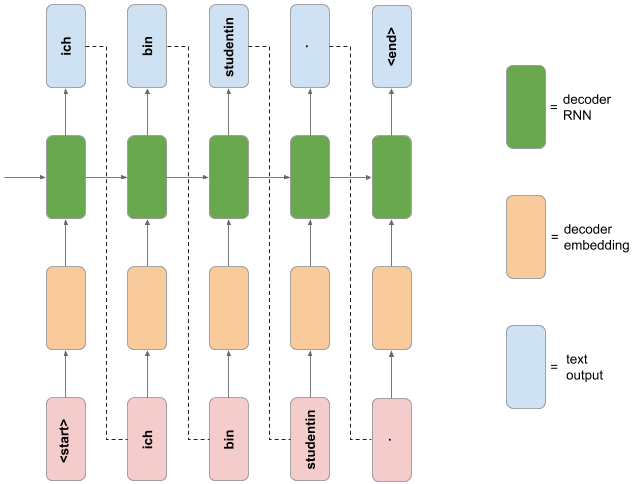

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding , LSTM , Dense

In [ ]:
# Build the model

vocab_size = len(tokenizer.word_index) + 1 # zero padding

class DecoderModel(Model):
    def __init__(self, **kwargs):
        super(DecoderModel, self).__init__(**kwargs)
        # An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        self.embedding = Embedding(input_dim = vocab_size, output_dim =128 , mask_zero= True )
        # An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        self.lstm = LSTM(512,return_sequences=True, return_state=True)
        # A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
        self.dense = Dense(vocab_size)
    
    # The call method should include the usual inputs argument, as well as the additional keyword arguments hidden_state and cell_state. The default value for these keyword arguments should be None.
    def call(self, inputs, hidden_state=None , cell_state=None): 
      x = self.embedding(inputs)
      if (hidden_state is not None) and (cell_state is not None):
        x , hid , cell = self.lstm(inputs = x , initial_state = [hidden_state,cell_state])
      else:
        x , hid , cell = self.lstm(inputs = x)
      
      outputs = self.dense(x)

      return outputs,hid,cell
        

In [ ]:
'''
Using the Dataset .take(1) method, extract a batch of English and German data examples from the training Dataset. 
Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, 
and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
'''
decoder_model = DecoderModel()

In [ ]:
for eng,ger in train_dataset.take(1):
  # Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states,
  hidden_state , cell_state = encoder_model(eng)
  #  then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
  output , hidden_state , cell_state  = decoder_model(ger , hidden_state = hidden_state , cell_state =  cell_state)

In [ ]:
# print the shape of the resulting decoder Tensor outputs.
print(tf.shape(output))
# Print the model summary for the decoder network.
print(decoder_model.summary())

tf.Tensor([  16   14 5745], shape=(3,), dtype=int32)
Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  735360    
                                                                 
 lstm_1 (LSTM)               multiple                  1312768   
                                                                 
 dense (Dense)               multiple                  2947185   
                                                                 
Total params: 4,995,313
Trainable params: 4,995,313
Non-trainable params: 0
_________________________________________________________________
None


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [ ]:
# Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), 
# and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).

def make_ger_pair(data):
  
  # take batch of data
  # input = start token >>> second to last element
  # [sample , sequence]
  inputs = data[: , 0:tf.shape(data)[1]-1]
  # output = second to last elemnt
  outputs =  data[: , 1:tf.shape(data)[1]]
  # return tuple containing German inputs and outputs 
  return  (inputs , outputs)
  '''
  # take batch of data
  # input = start token >>> second to last element
  # [sample , sequence , token]
  inputs = data[0:tf.shape(data)[0]-1 , : ]
  # output = second to last elemnt
  outputs =  data[1:tf.shape(data)[0], :]
  # return tuple containing German inputs and outputs 
  return  (inputs , outputs)
  '''

In [ ]:
for eng,ger in train_dataset.take(1):
  print(ger)
  inputs , outputs  = make_ger_pair(ger)
  print(inputs)
  print(outputs)
  print(inputs.shape)
  print(outputs.shape)

tf.Tensor(
[[   2    5   40  140  253    4    3    0    0    0    0    0    0    0]
 [   2    5   40   12   13  870    4    3    0    0    0    0    0    0]
 [   2    6  999   22   21    4    3    0    0    0    0    0    0    0]
 [   2   12 1043   13   42    4    3    0    0    0    0    0    0    0]
 [   2    9  727    4    3    0    0    0    0    0    0    0    0    0]
 [   2    6 2413    4    3    0    0    0    0    0    0    0    0    0]
 [   2    5   40   11    6  221    4    3    0    0    0    0    0    0]
 [   2   15   25   57  805    4    3    0    0    0    0    0    0    0]
 [   2   15  727  128    4    3    0    0    0    0    0    0    0    0]
 [   2   18   24   21   76    4    3    0    0    0    0    0    0    0]
 [   2  138   32   34  463   10    3    0    0    0    0    0    0    0]
 [   2    6    7 4537    4    3    0    0    0    0    0    0    0    0]
 [   2    5   19   45   89    4    3    0    0    0    0    0    0    0]
 [   2    6  210   11  192    4    3    

In [ ]:
# Define a function that computes the forward and backward pass for your translation model. 
# This function should take an English input, German input and German output as arguments, and should do the following:

In [ ]:
# define loss

# problem with multi-class classification  interger
# no softmax layer in LSTM (the vector of raw (non-normalized) predictions)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# create model
encoder_model = create_encoder()
decoder_model = DecoderModel()


In [ ]:
# Define a function to compute the forward and backward pass

@tf.function
def grad(eng_inputs,ger_inputs,ger_outputs):
  with tf.GradientTape() as tape:
    hidden_state , cell_state = encoder_model(eng_inputs)
    seq_out , _ , _ = decoder_model(ger_inputs,hidden_state=hidden_state,cell_state=cell_state)
    loss_val = loss(y_true = ger_outputs, y_pred = seq_out)
    # 2 model weight list
    train_var = encoder_model.trainable_variables + decoder_model.trainable_variables
    gradient = tape.gradient(loss_val, train_var)
  return loss_val , gradient


In [ ]:
# store loss for training record
train_loss_results = []

# validation loss record
val_loss_results = []

num_epochs = 5

for epoch in range(num_epochs):

  # mean loss for each epoch
  train_epoch_loss_avg = tf.keras.metrics.Mean()

  # Forward and backward pass (training)
  for eng,ger in train_dataset:
    # creates decoder inputs and outputs from the German sequences
    ger_inputs , ger_target = make_ger_pair(ger)
    # forwar pass , calculate loss and get gradient
    loss_val , gradient = grad(eng,ger_inputs,ger_target)
    # update weight
    train_var = encoder_model.trainable_variables + decoder_model.trainable_variables
    optimizer.apply_gradients(zip(gradient,train_var))

    # Compute current loss
    train_epoch_loss_avg(loss_val)
  
  # end epoch , record loss
  train_loss_results.append(train_epoch_loss_avg.result())

  # validation forward pass
  for eng,ger in val_dataset:
    # mean loss for each epoch
    val_epoch_loss_avg = tf.keras.metrics.Mean()
    # creates decoder inputs and outputs from the German sequences
    ger_inputs , ger_target = make_ger_pair(ger)
    # forwar pass , calculate loss and get gradient
    loss_val , gradient = grad(eng,ger_inputs,ger_target)
    # Compute current loss
    val_epoch_loss_avg(loss_val)
  # end epoch , record loss
  val_loss_results.append(val_epoch_loss_avg.result())

  print("Epoch {:03d}: Train_Loss: {:.3f}, Val_Loss: {:.3f}".format(epoch,train_epoch_loss_avg.result(),val_epoch_loss_avg.result()))


Epoch 000: Train_Loss: 5.533, Val_Loss: 4.989
Epoch 001: Train_Loss: 4.421, Val_Loss: 4.228
Epoch 002: Train_Loss: 3.536, Val_Loss: 3.445
Epoch 003: Train_Loss: 2.720, Val_Loss: 2.797
Epoch 004: Train_Loss: 1.978, Val_Loss: 2.246


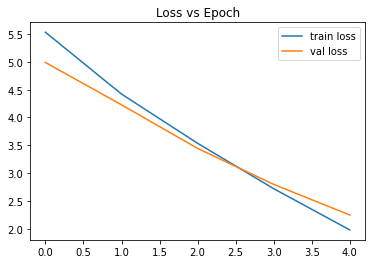

In [ ]:
# Plot the learning curves for loss vs epoch for both training and validation sets.

import matplotlib.pyplot as plt

epochs = list(range(num_epochs ))

plt.plot(epochs, train_loss_results, label = "train loss")
plt.plot(epochs, val_loss_results, label = "val loss")
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
# (optinal: save model weights)

encoder_model.save_weights('/content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone/model/encoder')
decoder_model.save_weights('/content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone/model/decoder')

In [ ]:
# load weight from previous trainnig
encoder_model.load_weights('/content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone/model/encoder')
decoder_model.load_weights('/content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone/model/decoder')

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [ ]:
# Randomly permute a sequence, and pick 5 example
permute_seq  = np.random.permutation(len(data_examples))[:5]
eng_sentence_pre_np = np.array(eng_sentence_pre)
german_sentence_pre_np = np.array(ger_sentence_pre)


english_sentence_sample = eng_sentence_pre_np[permute_seq]
german_sentence_sample = german_sentence_pre_np[permute_seq]

# Print text
for index in range(len(permute_seq)):
    print(f'English : {english_sentence_sample[index]} ')
    print(f'German : {german_sentence_sample[index]}')
    

English : tom is history . 
German : <start> tom ist geschichte . <end>
English : i have ten pens . 
German : <start> ich habe fueller dabei . <end>
English : beat the eggs . 
German : <start> schlag die eier . <end>
English : a dog was running . 
German : <start> ein hund rannte . <end>
English : we adopted tom . 
German : <start> wir haben tom adoptiert . <end>


In [ ]:
# Preprocess and embed the English sentence according to the model requirements.

# convert to dataset tensor
eng_sample_dataset = tf.data.Dataset.from_tensor_slices(english_sentence_sample)

# pre_process
def test_split_eng(eng):
    eng = tf.strings.split(eng, sep=' ')
    return eng

def test_embed_eng(eng):
    eng = embedding_layer(eng)
    return eng

def test_filter_length(eng):
    length = tf.constant(13,dtype = tf.int32)
    return tf.math.greater(length,tf.cast(len(eng),tf.int32))

def test_pad_eng(eng):
    paddings = [[13-len(eng),0] , [0,0]]
    eng = tf.pad(eng, paddings = paddings, mode='CONSTANT', constant_values=0)
    return eng

eng_sample_dataset  = eng_sample_dataset.map(test_split_eng)
eng_sample_dataset  = eng_sample_dataset.map(test_embed_eng)
eng_sample_dataset  = eng_sample_dataset.filter(test_filter_length)
eng_sample_dataset  = eng_sample_dataset.map(test_pad_eng)
eng_sample_dataset = eng_sample_dataset.batch(1)

print(eng_sample_dataset.element_spec)
print(next(iter(eng_sample_dataset.take(1))))


TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None)
tf.Tensor(
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.22104432 -0.01606884  0.00432623 ...  0.13655335  0.01242723
    0.00964247]
  [ 0.00813036  0.0639452  -0.10054474 ...  0.00130268  0.08961467
   -0.18078862]
  [ 0.012986    0.08981702  0.16017003 ...  0.06796802  0.13528903
   -0.022035  ]]], shape=(1, 13, 128), dtype=float32)


In [ ]:
# Translate

for i,english in enumerate(eng_sample_dataset): 
  # Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
  hidden_state , cell_state = encoder_model(english)
  
  # Predict German sentence 
  ger_sentence_predict = []
  # Starting with the special "<start>" token, 
  # create start token tensor # get correct dimestion
  ger_start = tf.constant(ger_word_index['<start>'] , shape=(1,1))
  # Use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
  # 1 step prediction from lstm layer
  predict , hidden_state , cell_state = decoder_model(ger_start,hidden_state=hidden_state,cell_state=cell_state)
  # normalize prediction
  predict = tf.nn.softmax(predict)
  # get the higest propability output and store in array
  predict_index = np.argmax(predict)
  ger_sentence_predict.append(predict_index)
  # get new input to next step
  ger_input = tf.constant(predict_index , shape=(1,1))
  # Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the "<end>" token is emitted, or when the sentence has reached a maximum length.
  while (predict_index != ger_word_index['<end>']) and (len(ger_sentence_predict) <= 13):
    predict , hidden_state , cell_state = decoder_model(ger_input,hidden_state=hidden_state,cell_state=cell_state)
    predict = tf.nn.softmax(predict)
    predict_index = np.argmax(predict)
    if predict_index == ger_word_index['<end>']:
      break
    ger_sentence_predict.append(predict_index)
    ger_input = tf.constant(predict_index , shape=(1,1))
  
  print(english_sentence_sample[i]+'  : ',end='')
  for ger in ger_sentence_predict:
    print(ger_index_word[str(ger)]+' ',end='')
  print('')


tom is history .  : tom ist rational . 
i have ten pens .  : ich habe einen pick up . 
beat the eggs .  : nimm mal kurz . 
a dog was running .  : der sturm bellte . 
we adopted tom .  : wir werden tom anrufen . 


In [ ]:
# convert to pdf
%%capture
%cd /content/gdrive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Capestone
!jupyter nbconvert --to pdf Capstone_Project.ipynb